In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import random
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape
import optuna
from datetime import datetime, timedelta
import torch
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LinearRegression
import warnings
warnings.filterwarnings("ignore")

In [29]:
def clear_df(df):
    df = df.rename(columns=lambda x: x.lower())
    date_range = pd.date_range(start=df.date[0], end=df.date[df.date.size-1], freq='D')
    df_full_dates = pd.DataFrame(date_range, columns=['date'])
    df['date'] = pd.to_datetime(df['date'])
    df = pd.merge(df_full_dates, df, how='left', on='date')
    return df

In [30]:
def return_weekends(df):
    return df[df.open.isna()].date

In [31]:
def fill_df(df):
    df.open = df.open.fillna(df.open.rolling(window = 3,min_periods = 1).mean())
    df.open = df.open.ffill()
    df.open = df.open.bfill()
    return df

In [32]:
def choice_news(n_news,news, df):
    uniq_dates = news.day.unique()
    res = pd.DataFrame()
    for date in uniq_dates:
        yesterday = pd.to_datetime(date)-timedelta(days=1)
        news_size = news[news.day==yesterday].shape[0]
        if news_size >= n_news:
            res = pd.concat([res,news[news.day==yesterday].sample(n_news)],ignore_index=True)
        else:
            res = pd.concat([res,news[news.day==yesterday]],ignore_index=True)
            temp_df = pd.DataFrame(index=(range(n_news-news_size)), columns=['day','score'])
            temp_df.day = date
            temp_df.score = 0
            res = pd.concat([res,temp_df],ignore_index=True)
        for i in range(n_news):
            df['news'+str(i)]=res.score[i::n_news].reset_index().score
    return df

In [77]:
def make_df(df:pd.DataFrame,news:pd.DataFrame,start_date:str,end_date:str,n_news:int = 20, lookback:int = 65):
    start_date = pd.to_datetime(start_date)-timedelta(days=lookback)
    df = clear_df(df)
    news['day'] = pd.to_datetime(news['day'])
    df['date'] = pd.to_datetime(df['date'])
    news = news[(news.day>=start_date) & (news.day<=end_date)].reset_index(drop=True)
    df = df[(df.date>=start_date) & (df.date<=end_date)].reset_index(drop=True)
    df=fill_df(df)
    df['news_size'] = news.groupby('day').count().news.reset_index(drop=True)
    print(news.groupby('day').count().news.reset_index(drop=True))
    df['year'] = df.date.apply(lambda x: x.year)
    df['month'] = df.date.apply(lambda x: x.month)
    df['day'] = df.date.apply(lambda x: x.day)
    print(df)
    df = df.drop(columns = ['date'])
    #news['score'] = news_regression(news)
    df = choice_news(n_news,news,df)
    for i in range(1,lookback+1):
        df['shift'+str(i)] = df.open.shift(i)
    df = df[lookback:]
    return df.reset_index(drop=True)

In [102]:
df = pd.read_csv('researches/data/IMOEX_2009-01-01_2024-04-08.csv')
news = pd.read_csv('researches/data/finam_news_scored.csv')
itog = make_df(df, news,'2017-04-04','2024-04-11')

0        2
1       20
2       20
3       40
4       20
        ..
2625     4
2626    39
2627    40
2628    38
2629    20
Name: news, Length: 2630, dtype: int64
           date     open  news_size  year  month  day
0    2017-01-29  2226.87          2  2017      1   29
1    2017-01-30  2263.63         20  2017      1   30
2    2017-01-31  2233.66         20  2017      1   31
3    2017-02-01  2219.19         40  2017      2    1
4    2017-02-02  2231.66         20  2017      2    2
...         ...      ...        ...   ...    ...  ...
2625 2024-04-07  3393.20          4  2024      4    7
2626 2024-04-08  3400.82         39  2024      4    8
2627 2024-04-09  3423.41         40  2024      4    9
2628 2024-04-10  3423.75         38  2024      4   10
2629 2024-04-11  3423.84         20  2024      4   11

[2630 rows x 6 columns]


In [103]:
itog

,open,news_size,year,month,day,news0,news1,news2,news3,news4,news5,news6,news7,news8,news9,news10,news11,news12,news13,news14,news15,news16,news17,news18,news19,shift1,shift2,shift3,shift4,shift5,shift6,shift7,shift8,shift9,shift10,shift11,shift12,shift13,shift14,shift15,...,shift26,shift27,shift28,shift29,shift30,shift31,shift32,shift33,shift34,shift35,shift36,shift37,shift38,shift39,shift40,shift41,shift42,shift43,shift44,shift45,shift46,shift47,shift48,shift49,shift50,shift51,shift52,shift53,shift54,shift55,shift56,shift57,shift58,shift59,shift60,shift61,shift62,shift63,shift64,shift65
0,2007.900,40,2017,4,4,0.020985,0.030779,0.396039,0.276064,0.271680,0.276015,-0.030067,0.224085,0.020985,-0.222497,0.052247,0.020985,0.078064,-0.015642,0.092762,-0.385789,-0.341033,0.020985,-0.135605,0.327334,1998.55,2021.16,2023.08,2021.16,2025.00,2032.49,2016.95,2034.100,2047.780,2056.575,2047.780,2065.370,2042.650,2045.190,2038.990,...,2010.850,2052.11,2047.59,2056.63,2046.610,2054.610,2046.610,2062.610,2034.280,2057.74,2095.510,2106.960,2106.960,2106.960,2123.915,2128.980,2118.850,2132.470,2148.580,2143.64,2148.58,2138.70,2140.20,2162.13,2165.12,2176.79,2184.515,2176.790,2192.240,2215.340,2210.870,2228.85,2219.49,2225.575,2219.490,2231.660,2219.190,2233.660,2263.630,2226.870
1,2028.710,20,2017,4,5,-0.336559,-0.077252,0.020985,-0.055723,0.184534,-0.059958,-0.143180,-0.100524,0.181920,-0.061632,0.009293,-0.369229,0.199081,0.067749,-0.036092,0.158240,-0.082145,-0.142370,0.239470,-0.183924,2007.90,1998.55,2021.16,2023.08,2021.16,2025.00,2032.49,2016.950,2034.100,2047.780,2056.575,2047.780,2065.370,2042.650,2045.190,...,1977.750,2010.85,2052.11,2047.59,2056.630,2046.610,2054.610,2046.610,2062.610,2034.28,2057.740,2095.510,2106.960,2106.960,2106.960,2123.915,2128.980,2118.850,2132.470,2148.58,2143.64,2148.58,2138.70,2140.20,2162.13,2165.12,2176.790,2184.515,2176.790,2192.240,2215.340,2210.87,2228.85,2219.490,2225.575,2219.490,2231.660,2219.190,2233.660,2263.630
2,2052.050,38,2017,4,6,0.050213,-0.015001,-0.227731,0.110109,0.285810,-0.030945,-0.177885,0.097706,-0.156368,0.218056,0.038374,-0.091165,0.246630,-0.115323,0.020985,-0.081370,0.020985,0.097773,0.283454,-0.038398,2028.71,2007.90,1998.55,2021.16,2023.08,2021.16,2025.00,2032.490,2016.950,2034.100,2047.780,2056.575,2047.780,2065.370,2042.650,...,1994.300,1977.75,2010.85,2052.11,2047.590,2056.630,2046.610,2054.610,2046.610,2062.61,2034.280,2057.740,2095.510,2106.960,2106.960,2106.960,2123.915,2128.980,2118.850,2132.47,2148.58,2143.64,2148.58,2138.70,2140.20,2162.13,2165.120,2176.790,2184.515,2176.790,2192.240,2215.34,2210.87,2228.850,2219.490,2225.575,2219.490,2231.660,2219.190,2233.660
3,2046.780,20,2017,4,7,0.299498,-0.158728,0.272748,0.020985,-0.039825,-0.173781,0.120413,0.018895,-0.061632,-0.010522,0.116940,-0.077252,-0.065529,0.109313,0.020985,0.104178,-0.212818,0.019399,0.020985,0.228440,2052.05,2028.71,2007.90,1998.55,2021.16,2023.08,2021.16,2025.000,2032.490,2016.950,2034.100,2047.780,2056.575,2047.780,2065.370,...,1977.750,1994.30,1977.75,2010.85,2052.110,2047.590,2056.630,2046.610,2054.610,2046.61,2062.610,2034.280,2057.740,2095.510,2106.960,2106.960,2106.960,2123.915,2128.980,2118.85,2132.47,2148.58,2143.64,2148.58,2138.70,2140.20,2162.130,2165.120,2176.790,2184.515,2176.790,2192.24,2215.34,2210.870,2228.850,2219.490,2225.575,2219.490,2231.660,2219.190
4,2049.415,4,2017,4,8,-0.020270,0.020985,0.020985,0.210170,0.154260,0.052516,0.271680,0.020985,-0.032404,0.281348,0.116503,0.300385,0.128557,-0.025404,0.026916,0.066832,-0.222497,0.012337,0.152171,-0.218749,2046.78,2052.05,2028.71,2007.90,1998.55,2021.16,2023.08,2021.160,2025.000,2032.490,2016.950,2034.100,2047.780,2056.575,2047.780,...,1972.660,1977.75,1994.30,1977.75,2010.850,2052.110,2047.590,2056.630,2046.610,2054.61,2046.610,2062.610,2034.280,2057.740,2095.510,2106.960,2106.960,2106.960,2123.915,2128.98,2118.85,2132.47,2148.58,2143.64,2148.58,2138.70,2140.200,2162.130,2165.120,2176.790,2184.515,2176.79,2192.24,2215.340,2210.870,

In [104]:
itog.to_csv('reserches/data/for_catboost_imoex.csv',index=False)

In [93]:
news.tail(40)

,day,news,score
101390,2024-04-10,Редомициляция Ozon должна пройти гладко,0.043857
101391,2024-04-10,"Дивидендная доходность акций ""Сбера"" за 2023 г...",-0.086472
101392,2024-04-10,Главная проблема российской экономики - огромн...,-0.069023
101393,2024-04-10,Курс доллара может незначительно ослабнуть,-0.077252
101394,2024-04-10,"""Эталон"" реализует грамотную стратегию",0.020985
101395,2024-04-10,Вторая половина недели может оказаться волатил...,0.073026
101396,2024-04-10,"Какие дивиденды ждать от компании ""Мать и дитя""",0.063999
101397,2024-04-10,Актуальный диапазон для Brent - $90-95 за бар...,0.227559
101398,2024-04-10,Проинфляционные риски продолжают нарастать,-0.038947
101399,2024-04-10,Positive Technologies остается одним из фавор...,-0.090877


In [83]:
itog

,open,news_size,year,month,day,news0,news1,news2,news3,news4,news5,news6,news7,news8,news9,news10,news11,news12,news13,news14,news15,news16,news17,news18,news19,shift1,shift2,shift3,shift4,shift5,shift6,shift7,shift8,shift9,shift10,shift11,shift12,shift13,shift14,shift15,...,shift26,shift27,shift28,shift29,shift30,shift31,shift32,shift33,shift34,shift35,shift36,shift37,shift38,shift39,shift40,shift41,shift42,shift43,shift44,shift45,shift46,shift47,shift48,shift49,shift50,shift51,shift52,shift53,shift54,shift55,shift56,shift57,shift58,shift59,shift60,shift61,shift62,shift63,shift64,shift65
0,113.28,20,2024,4,5,-0.021973,0.161979,0.166526,-0.018268,0.120139,0.123108,0.133265,0.050932,-0.470731,0.408729,0.199849,0.033765,0.058202,-0.175646,0.109142,0.268707,0.020985,0.027887,0.122458,-0.04415,116.50,116.59,115.72,115.45,115.09,114.835,115.090,114.580,114.950,114.690,114.490,114.060,114.285,114.060,114.510,...,115.290,115.29,115.35,115.29,115.41,115.41,115.35,114.83,114.67,114.83,114.51,113.94,113.56,113.73,112.02,112.02,111.885,112.020,111.750,114.720,116.640,117.650,118.350,117.65,119.05,119.07,118.89,118.18,118.32,118.63,118.32,118.94,119.43,118.74,118.35,118.25,118.445,118.250,118.640,118.400
1,113.28,2,2024,4,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.28,116.50,116.59,115.72,115.45,115.090,114.835,115.090,114.580,114.950,114.690,114.490,114.060,114.285,114.060,...,115.390,115.29,115.29,115.35,115.29,115.41,115.41,115.35,114.83,114.67,114.83,114.51,113.94,113.56,113.73,112.02,112.020,111.885,112.020,111.750,114.720,116.640,117.650,118.35,117.65,119.05,119.07,118.89,118.18,118.32,118.63,118.32,118.94,119.43,118.74,118.35,118.250,118.445,118.250,118.640
2,113.28,4,2024,4,7,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,113.28,113.28,116.50,116.59,115.72,115.450,115.090,114.835,115.090,114.580,114.950,114.690,114.490,114.060,114.285,...,115.480,115.39,115.29,115.29,115.35,115.29,115.41,115.41,115.35,114.83,114.67,114.83,114.51,113.94,113.56,113.73,112.020,112.020,111.885,112.020,111.750,114.720,116.640,117.65,118.35,117.65,119.05,119.07,118.89,118.18,118.32,118.63,118.32,118.94,119.43,118.74,118.350,118.250,118.445,118.250
3,113.62,39,2024,4,8,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,113.28,113.28,113.28,116.50,116.59,115.720,115.450,115.090,114.835,115.090,114.580,114.950,114.690,114.490,114.060,...,115.420,115.48,115.39,115.29,115.29,115.35,115.29,115.41,115.41,115.35,114.83,114.67,114.83,114.51,113.94,113.56,113.730,112.020,112.020,111.885,112.020,111.750,114.720,116.64,117.65,118.35,117.65,119.05,119.07,118.89,118.18,118.32,118.63,118.32,118.94,119.43,118.740,118.350,118.250,118.445
4,113.25,40,2024,4,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.62,113.28,113.28,113.28,116.50,116.590,115.720,115.450,115.090,114.835,115.090,114.580,114.950,114.690,114.490,...,114.880,115.42,115.48,115.39,115.29,115.29,115.35,115.29,115.41,115.41,115.35,114.83,114.67,114.83,114.51,113.94,113.560,113.730,112.020,112.020,111.885,112.020,111.750,114.72,116.64,117.65,118.35,117.65,119.05,119.07,118.89,118.18,118.32,118.63,118.32,118.94,119.430,118.740,118.350,118.250
5,114.26,38,2024,4,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.25,113.62,113.28,113.28,113.28,116.500,116.590,115.720,115.450,115.090,114.835,115.090,114.580,114.950,114.690,...,115.010,114.88,115.42,115.48,115.39,115.29,115.29,115.35,115.29,115.41,115.41,115.35,114.83,114.67,114.83,114.51,113.940,113.560,113.730,112.020,112.020,111.885,112.020,111.75,114.72,116.64,117.65,118.35,117.65,119.05,119.07,118.89,118.18,118.32,118.63,118.32,118.940,119.430,118.740,118.350
6,114.23,20,2024,4,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [66]:
def query_for_tomorrow(df_filled:pd.DataFrame,news:pd.DataFrame,n_news=20,lookback=65):
    news['day'] = pd.to_datetime(news['day'])
    cur_date = news.iloc[-1].day
    query = pd.DataFrame()
    news_size = news[news.day==cur_date].shape[0]
    query['news_size'] = [news_size]
    query['year'] = [cur_date.year]
    query['month'] = [cur_date.month]
    query['day'] = [cur_date.day]
    res = news[news.day==cur_date].sample(min(n_news,news_size)).score
    for i in range(n_news-min(n_news,news_size)):
        res = res.append(pd.Series([0.0]),ignore_index=True)
    res = res.reset_index(drop=True)
    for i in range(n_news):
        query['news'+str(i)]=res[i]
    lags = df_filled[df_filled.date.between(str(cur_date-timedelta(days=lookback)),str(cur_date))].open.reset_index(drop=True)
    for i in range(1,lookback+1):
        query['shift'+str(i)] = lags[lags.size-i]
    return query

In [90]:
news = pd.read_csv('reserches/data/finam_news_scored.csv')

In [100]:
df = pd.read_csv('reserches/data/IMOEX_filled.csv')

In [101]:
df

,date,open
0,2009-01-11,619.53
1,2009-01-12,635.40
2,2009-01-13,653.28
3,2009-01-14,655.16
4,2009-01-15,610.36
...,...,...
5565,2024-04-07,3393.20
5566,2024-04-08,3400.82
5567,2024-04-09,3423.41
5568,2024-04-10,3423.75


In [74]:
query = query_for_tomorrow(df,news)

In [75]:
query

,news_size,year,month,day,news0,news1,news2,news3,news4,news5,news6,news7,news8,news9,news10,news11,news12,news13,news14,news15,news16,news17,news18,news19,shift1,shift2,shift3,shift4,shift5,shift6,shift7,shift8,shift9,shift10,shift11,shift12,shift13,shift14,shift15,shift16,...,shift26,shift27,shift28,shift29,shift30,shift31,shift32,shift33,shift34,shift35,shift36,shift37,shift38,shift39,shift40,shift41,shift42,shift43,shift44,shift45,shift46,shift47,shift48,shift49,shift50,shift51,shift52,shift53,shift54,shift55,shift56,shift57,shift58,shift59,shift60,shift61,shift62,shift63,shift64,shift65
0,40,2024,4,11,0.293921,-0.268126,0.151916,-0.033312,-0.522769,-0.040007,0.188097,-0.081016,0.021902,0.018882,-0.522769,-0.334647,-0.029676,0.188657,0.159051,0.188097,0.151916,-0.060747,-0.033312,0.021902,114.23,114.26,113.25,113.62,113.28,113.28,113.28,116.5,116.59,115.72,115.45,115.09,114.835,115.09,114.58,114.95,...,115.01,114.945,115.01,114.88,115.42,115.48,115.39,115.29,115.29,115.35,115.29,115.41,115.41,115.35,114.83,114.67,114.83,114.51,113.94,113.56,113.73,112.02,112.02,111.885,112.02,111.75,114.72,116.64,117.65,118.35,117.65,119.05,119.07,118.89,118.18,118.32,118.63,118.32,118.94,119.43


In [76]:
query.to_csv('reserches/data/yesterday_query_spbe.csv',index=False)

In [60]:
df = clear_df(df)
df = fill_df(df)

In [54]:
df[df.date>='2017-04-04'].reset_index()

,index,date,open
0,3005,2017-04-04,2007.900
1,3006,2017-04-05,2028.710
2,3007,2017-04-06,2052.050
3,3008,2017-04-07,2046.780
4,3009,2017-04-08,2049.415
...,...,...,...
2560,5565,2024-04-07,3393.200
2561,5566,2024-04-08,3400.820
2562,5567,2024-04-09,3423.410
2563,5568,2024-04-10,3423.750


In [44]:
itog = make_df(df,news,'2017-04-04','2024-04-11')

           date     open  news_size  year  month  day
0    2017-01-29  2226.87        2.0  2017      1   29
1    2017-01-30  2263.63       20.0  2017      1   30
2    2017-01-31  2233.66       20.0  2017      1   31
3    2017-02-01  2219.19       40.0  2017      2    1
4    2017-02-02  2231.66       20.0  2017      2    2
...         ...      ...        ...   ...    ...  ...
2625 2024-04-07  3393.20        NaN  2024      4    7
2626 2024-04-08  3400.82        NaN  2024      4    8
2627 2024-04-09  3423.41        NaN  2024      4    9
2628 2024-04-10  3423.75        NaN  2024      4   10
2629 2024-04-11  3423.84        NaN  2024      4   11

[2630 rows x 6 columns]


In [45]:
itog

,open,news_size,year,month,day,news0,news1,news2,news3,news4,news5,news6,news7,news8,news9,news10,news11,news12,news13,news14,news15,news16,news17,news18,news19,shift1,shift2,shift3,shift4,shift5,shift6,shift7,shift8,shift9,shift10,shift11,shift12,shift13,shift14,shift15,...,shift26,shift27,shift28,shift29,shift30,shift31,shift32,shift33,shift34,shift35,shift36,shift37,shift38,shift39,shift40,shift41,shift42,shift43,shift44,shift45,shift46,shift47,shift48,shift49,shift50,shift51,shift52,shift53,shift54,shift55,shift56,shift57,shift58,shift59,shift60,shift61,shift62,shift63,shift64,shift65
0,2007.900,40.0,2017,4,4,0.020985,-0.130072,0.019253,0.433806,0.198675,0.224085,0.046463,-0.058132,0.026916,-0.030067,-0.135605,0.092762,0.078064,0.065160,0.107154,0.327334,0.044305,0.023005,0.052247,0.020985,1998.55,2021.16,2023.08,2021.16,2025.00,2032.49,2016.95,2034.100,2047.780,2056.575,2047.780,2065.370,2042.650,2045.190,2038.990,...,2010.850,2052.11,2047.59,2056.63,2046.610,2054.610,2046.610,2062.610,2034.280,2057.74,2095.510,2106.960,2106.960,2106.960,2123.915,2128.980,2118.850,2132.470,2148.580,2143.64,2148.58,2138.70,2140.20,2162.13,2165.12,2176.79,2184.515,2176.790,2192.240,2215.340,2210.870,2228.85,2219.49,2225.575,2219.490,2231.660,2219.190,2233.660,2263.630,2226.870
1,2028.710,20.0,2017,4,5,-0.075439,0.040177,0.199081,0.184534,-0.212660,-0.028354,-0.077252,0.037204,-0.114614,0.195935,0.018882,-0.369229,-0.143180,0.020985,-0.045721,-0.416384,-0.038111,-0.061632,0.194019,0.193674,2007.90,1998.55,2021.16,2023.08,2021.16,2025.00,2032.49,2016.950,2034.100,2047.780,2056.575,2047.780,2065.370,2042.650,2045.190,...,1977.750,2010.85,2052.11,2047.59,2056.630,2046.610,2054.610,2046.610,2062.610,2034.28,2057.740,2095.510,2106.960,2106.960,2106.960,2123.915,2128.980,2118.850,2132.470,2148.58,2143.64,2148.58,2138.70,2140.20,2162.13,2165.12,2176.790,2184.515,2176.790,2192.240,2215.340,2210.87,2228.85,2219.490,2225.575,2219.490,2231.660,2219.190,2233.660,2263.630
2,2052.050,38.0,2017,4,6,-0.156368,-0.177885,0.110109,0.283454,0.020985,0.285810,0.097706,-0.115323,0.097773,0.020985,0.246630,-0.081370,-0.015001,0.218056,0.050213,-0.227731,-0.038398,-0.091165,-0.030945,0.038374,2028.71,2007.90,1998.55,2021.16,2023.08,2021.16,2025.00,2032.490,2016.950,2034.100,2047.780,2056.575,2047.780,2065.370,2042.650,...,1994.300,1977.75,2010.85,2052.11,2047.590,2056.630,2046.610,2054.610,2046.610,2062.61,2034.280,2057.740,2095.510,2106.960,2106.960,2106.960,2123.915,2128.980,2118.850,2132.47,2148.58,2143.64,2148.58,2138.70,2140.20,2162.13,2165.120,2176.790,2184.515,2176.790,2192.240,2215.34,2210.87,2228.850,2219.490,2225.575,2219.490,2231.660,2219.190,2233.660
3,2046.780,20.0,2017,4,7,0.064844,0.104178,0.120413,0.299499,0.019399,-0.212818,-0.173781,0.026916,0.020985,0.018895,0.051909,-0.077252,0.020985,-0.039825,0.408102,-0.208907,-0.158728,0.272748,-0.024349,0.065501,2052.05,2028.71,2007.90,1998.55,2021.16,2023.08,2021.16,2025.000,2032.490,2016.950,2034.100,2047.780,2056.575,2047.780,2065.370,...,1977.750,1994.30,1977.75,2010.85,2052.110,2047.590,2056.630,2046.610,2054.610,2046.61,2062.610,2034.280,2057.740,2095.510,2106.960,2106.960,2106.960,2123.915,2128.980,2118.85,2132.47,2148.58,2143.64,2148.58,2138.70,2140.20,2162.130,2165.120,2176.790,2184.515,2176.790,2192.24,2215.34,2210.870,2228.850,2219.490,2225.575,2219.490,2231.660,2219.190
4,2049.415,4.0,2017,4,8,-0.222497,-0.032404,0.128557,0.210170,-0.020270,0.026916,0.066832,0.020985,-0.025404,0.300385,0.052516,0.271680,0.281348,0.116503,0.012337,0.152171,-0.218749,0.020985,0.020985,0.154260,2046.78,2052.05,2028.71,2007.90,1998.55,2021.16,2023.08,2021.160,2025.000,2032.490,2016.950,2034.100,2047.780,2056.575,2047.780,...,1972.660,1977.75,1994.30,1977.75,2010.850,2052.110,2047.590,2056.630,2046.610,2054.61,2046.610,2062.610,2034.280,2057.740,2095.510,2106.960,2106.960,2106.960,2123.915,2128.98,2118.85,2132.47,2148.58,2143.64,2148.58,2138.70,2140.200,2162.130,2165.120,2176.790,2184.515,2176.79,2192.24,2215.340,221

In [18]:
itog.to_csv('reserches/data/for_catboost_spb.csv', index=False)

In [59]:
df = clear_df(df)
df = fill_df(df)


AttributeError: 'DataFrame' object has no attribute 'date'

In [33]:
df = df[df.date <= '2024-04-04']
df

,date,open
0,2015-11-25,70.62
1,2015-11-26,70.55
2,2015-11-27,69.99
3,2015-11-28,70.27
4,2015-11-29,69.99
...,...,...
3049,2024-03-31,115.09
3050,2024-04-01,115.45
3051,2024-04-02,115.72
3052,2024-04-03,116.59


In [34]:
df.to_csv('reserches/data/SPBIRUS2_filled.csv',index=False)

In [16]:
query_for_tomorrow(df,news)

,news_size,year,month,day,news0,news1,news2,news3,news4,news5,news6,news7,news8,news9,news10,news11,news12,news13,news14,news15,news16,news17,news18,news19,shift1,shift2,shift3,shift4,shift5,shift6,shift7,shift8,shift9,shift10,shift11,shift12,shift13,shift14,shift15,shift16,...,shift26,shift27,shift28,shift29,shift30,shift31,shift32,shift33,shift34,shift35,shift36,shift37,shift38,shift39,shift40,shift41,shift42,shift43,shift44,shift45,shift46,shift47,shift48,shift49,shift50,shift51,shift52,shift53,shift54,shift55,shift56,shift57,shift58,shift59,shift60,shift61,shift62,shift63,shift64,shift65
0,20,2024,4,4,0.109142,0.199849,-0.175646,0.161979,-0.04415,0.268707,0.033765,0.120139,0.122458,-0.021973,0.020985,0.133265,0.058202,0.027887,0.408729,0.166526,-0.470731,0.123108,0.050932,-0.018268,3399.81,3381.95,3369.32,3343.66,3313.17,3310.715,3313.17,3308.26,3291.7,3286.2,3251.24,3289.28,3288.015,3289.28,3286.75,3268.87,...,3309.31,3309.31,3304.085,3309.31,3298.86,3305.79,3278.01,3259.0,3246.015,3259.0,3233.03,3215.53,3220.26,3186.06,3152.75,3152.75,3162.88,3152.75,3173.01,3236.85,3247.46,3269.84,3259.81,3269.84,3249.78,3261.52,3250.3,3241.57,3231.3,3246.24,3231.3,3261.18,3240.57,3234.44,3218.91,3229.48,3224.955,3229.48,3220.43,3201.48


In [2]:
df_spb = pd.read_csv('reserches/data/SPBIRUS2_df_clearn.csv')

In [3]:
df_spb.isna().sum()

DATE    0
OPEN    0
dtype: int64

In [17]:
itog_df = make_df(df,news,'2017-04-04','2024-04-04')

In [17]:
df = pd.read_csv('reserches/data/for_catboost.csv')

In [21]:
df = df.set_index(pd.date_range('2017-04-04','2024-04-04'),drop = True)

In [22]:
X = df.drop('open',axis=1)
y = df.open

In [23]:
r = 0.75
train_x = X.iloc[:round(X.shape[0]*r)]
valid_x = X.iloc[round(X.shape[0]*r):]
train_y = y.iloc[:round(y.size*r)]
valid_y = y.iloc[round(y.size*r):]

In [24]:
train_x

,news_size,year,month,day,news0,news1,news2,news3,news4,news5,news6,news7,news8,news9,news10,news11,news12,news13,news14,news15,news16,news17,news18,news19,shift1,shift2,shift3,shift4,shift5,shift6,shift7,shift8,shift9,shift10,shift11,shift12,shift13,shift14,shift15,shift16,...,shift26,shift27,shift28,shift29,shift30,shift31,shift32,shift33,shift34,shift35,shift36,shift37,shift38,shift39,shift40,shift41,shift42,shift43,shift44,shift45,shift46,shift47,shift48,shift49,shift50,shift51,shift52,shift53,shift54,shift55,shift56,shift57,shift58,shift59,shift60,shift61,shift62,shift63,shift64,shift65
2017-04-04,40,2017,4,4,0.065160,-0.015642,-0.341033,0.210170,0.020985,-0.130072,0.020985,-0.135605,0.198675,0.023005,0.396039,-0.058132,-0.385789,0.020985,0.052247,0.211859,0.020985,0.020985,0.026916,0.327334,1998.550,2021.160,2023.08,2021.16,2025.000,2032.490,2016.950,2034.100,2047.780,2056.575,2047.780,2065.370,2042.650,2045.190,2038.990,2015.590,...,2010.85,2052.11,2047.59,2056.63,2046.61,2054.61,2046.61,2062.61,2034.28,2057.74,2095.51,2106.96,2106.96,2106.96,2123.915,2128.980,2118.850,2132.470,2148.580,2143.64,2148.58,2138.700,2140.200,2162.130,2165.120,2176.790,2184.515,2176.790,2192.240,2215.340,2210.870,2228.850,2219.490,2225.575,2219.490,2231.660,2219.190,2233.660,2263.630,2226.870
2017-04-05,20,2017,4,5,-0.036092,-0.336559,-0.077252,-0.055723,0.060756,-0.100524,-0.114614,-0.143180,0.009293,0.158240,0.181920,0.112642,-0.212660,0.018882,0.020985,0.020985,0.184534,0.195935,-0.061632,0.239470,2007.900,1998.550,2021.16,2023.08,2021.160,2025.000,2032.490,2016.950,2034.100,2047.780,2056.575,2047.780,2065.370,2042.650,2045.190,2038.990,...,1977.75,2010.85,2052.11,2047.59,2056.63,2046.61,2054.61,2046.61,2062.61,2034.28,2057.74,2095.51,2106.96,2106.96,2106.960,2123.915,2128.980,2118.850,2132.470,2148.58,2143.64,2148.580,2138.700,2140.200,2162.130,2165.120,2176.790,2184.515,2176.790,2192.240,2215.340,2210.870,2228.850,2219.490,2225.575,2219.490,2231.660,2219.190,2233.660,2263.630
2017-04-06,38,2017,4,6,0.097706,-0.081370,0.038374,-0.030945,0.050213,0.246630,-0.227731,0.283454,0.218056,0.285810,-0.091165,-0.115323,-0.177885,-0.038398,0.097773,-0.015001,0.110109,-0.156368,0.020985,0.020985,2028.710,2007.900,1998.55,2021.16,2023.080,2021.160,2025.000,2032.490,2016.950,2034.100,2047.780,2056.575,2047.780,2065.370,2042.650,2045.190,...,1994.30,1977.75,2010.85,2052.11,2047.59,2056.63,2046.61,2054.61,2046.61,2062.61,2034.28,2057.74,2095.51,2106.96,2106.960,2106.960,2123.915,2128.980,2118.850,2132.47,2148.58,2143.640,2148.580,2138.700,2140.200,2162.130,2165.120,2176.790,2184.515,2176.790,2192.240,2215.340,2210.870,2228.850,2219.490,2225.575,2219.490,2231.660,2219.190,2233.660
2017-04-07,20,2017,4,7,0.104178,0.065501,0.020985,0.026916,0.051909,-0.158728,0.115330,-0.173781,0.120413,-0.077252,-0.065529,0.020985,-0.061632,0.083425,0.081194,-0.024349,0.020985,0.272748,0.181175,0.020985,2052.050,2028.710,2007.90,1998.55,2021.160,2023.080,2021.160,2025.000,2032.490,2016.950,2034.100,2047.780,2056.575,2047.780,2065.370,2042.650,...,1977.75,1994.30,1977.75,2010.85,2052.11,2047.59,2056.63,2046.61,2054.61,2046.61,2062.61,2034.28,2057.74,2095.51,2106.960,2106.960,2106.960,2123.915,2128.980,2118.85,2132.47,2148.580,2143.640,2148.580,2138.700,2140.200,2162.130,2165.120,2176.790,2184.515,2176.790,2192.240,2215.340,2210.870,2228.850,2219.490,2225.575,2219.490,2231.660,2219.190
2017-04-08,4,2017,4,8,-0.218749,-0.025404,0.128557,-0.032404,0.281348,0.300385,-0.020270,0.020985,0.271680,0.152171,-0.222497,0.066832,0.012337,0.116503,0.020985,0.026916,0.154260,0.020985,0.210170,0.052516,2046.780,2052.050,2028.71,2007.90,1998.550,2021.160,2023.080,2021.160,2025.000,2032.490,2016.950,2034.100,2047.780,2056.575,2047.780,2065.370,...,1972.66,1977.75,1994.30,1977.75,2010.85,2052.11,2047.59,2056.63,2046.61,2054.61,2046.61,2062.61,2034.28,2057.74,2095.510,2106.960,2106.960,2106.960,2123.915,2128.98,2118.85,2132.470,2148.580,2143.640,2148.580,2138.700,2140.200,2162.130,2165.120,2

In [25]:
import joblib
model = joblib.load('reserches/data/catboost.joblib')
pred_y = model.predict(valid_x)
mape(valid_y,pred_y)

0.020148841490414342

In [26]:
predictions = pd.Series(pred_y)
predictions.index = valid_y.index

Text(0.5, 1.0, 'IMOEX using Catboost')

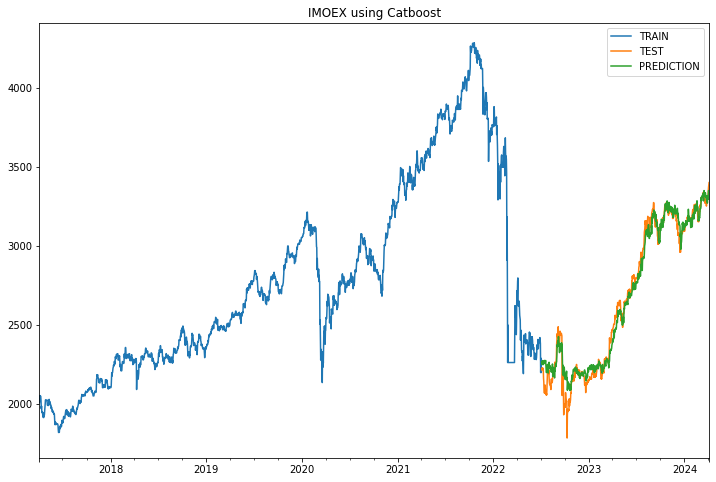

In [27]:
train_y.plot(legend=True,label='TRAIN')
valid_y.plot(legend=True,label='TEST',figsize=(12,8))
predictions.plot(legend=True,label='PREDICTION')
plt.title('IMOEX using Catboost')

In [214]:
joblib.dump(model,'reserches/data/catboost.joblib')

In [216]:
model1 = CatBoostRegressor()

In [219]:
model1 = joblib.load('reserches/data/catboost.joblib')

In [222]:
model1.predict(valid_x)

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

#Тюним

In [46]:
def objective(trial):
    r = 0.75
    train_x = X.iloc[:round(X.shape[0]*r)]
    valid_x = X.iloc[round(X.shape[0]*r):]
    train_y = y.iloc[:round(y.size*r)]
    valid_y = y.iloc[round(y.size*r):]
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg",1,10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        )
    }


    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cb = CatBoostRegressor(**params)

    cb.fit(train_x, train_y, eval_set=[(valid_x, valid_y)],verbose=0,early_stopping_rounds=100)

    preds = cb.predict(valid_x)
    cb_mape = mape(valid_y, preds)
    return cb_mape

In [47]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)
df_trials = study.trials_dataframe()
df_trials.to_csv('reserches/data//nice_try_for_spb.csv')

[I 2024-04-11 06:52:32,721] A new study created in memory with name: no-name-498f0c05-dceb-412d-957a-ea9b1dc00c16
[I 2024-04-11 06:52:33,184] Trial 0 finished with value: 0.0183656342037604 and parameters: {'learning_rate': 0.09272729606675101, 'depth': 4, 'l2_leaf_reg': 10, 'min_data_in_leaf': 34, 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.0183656342037604.
[I 2024-04-11 06:52:48,598] Trial 1 finished with value: 0.015985689770358958 and parameters: {'learning_rate': 0.01217925799437206, 'depth': 8, 'l2_leaf_reg': 6, 'min_data_in_leaf': 82, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8558781817180878}. Best is trial 1 with value: 0.015985689770358958.
[I 2024-04-11 06:52:54,199] Trial 2 finished with value: 0.014924317555769392 and parameters: {'learning_rate': 0.02116610468522931, 'depth': 7, 'l2_leaf_reg': 6, 'min_data_in_leaf': 47, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.920971864945613}. Best is trial 2 with value: 0.014924317555769392.
[I 2024-04-11 

In [48]:
model = CatBoostRegressor(**study.best_trial.params)

In [55]:
joblib.dump(model,'reserches/data/catboost_spb.joblib')

['/home/jupyter/datasphere/project/raw_date/catboost_spb.joblib']

In [66]:
cb_jl=joblib.load('reserches/data/catboost_spb.joblib')

In [68]:
cb_jl.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 8,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'use_best_model': False,
 'random_seed': 0,
 'depth': 5,
 'posterior_sampling': False,
 'border_count': 254,
 'bagging_temperature': 3.684213638305664,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 67,
 'loss_function': 'RM